# QAFKA

## Welcome to QAFKA jupyter notebook


In order to run QAFKA please follow the instructions in the following blocks.
For more information please visit [link to paper](https://www.google.com)

### Parameters Initialization and Setup

In the next block we will import the relevant packages for QAFKA.
Then, we will define some important parameters for our run.

**numOfBins** - Specifies the number of bins in the histogram of the number of blinking events (default: 20)

**chop** - Specifies which frames of the experiment you would like to analyze. For example: chop = \[0, 1000\] will cause QAFKA to analyze the experiment between the first frame and the 1000th frame.

**pixel_length** - Specifies the experiment's pixel size \[nm\]

**scale_size** - Specifies the resolution scaling. For example: scale_size = 3 and pixel_length = 150 \[nm\] would results in a reconstrcuted image with grid size of 50 \[nm\].

**emitters_size** - Specifies the emitters merging radius for detection. If two clusters would be located within this radius they would be considered as a single cluster.

**numOfClusters** - Specifies the number of simulated clusters in each simulated experiment

**file_names** - Specifies the names of the TIFF files (at least one experiment is required). For example: 'first_exp.tif'.

**qualityThreshold** - Specifies the minimal fitting score for the localization block. (default: 0.85)

In [1]:
!pip install tiffcapture
!pip install torch

from datasets import *
from dataloaders import *
from neural_network import *
from trainers import *
from utils import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

numOfBins = 20
chop = [0, 5000]
pixel_length = 157 #[nm]
scale_size = 3
merging_radius = 150 #[nm]
file_names = [r'D:\Project\data\CTLA4\mEos3.2.tif']
qualityThreshold = 0.85

### Run Configuration

**LoadData** - Determines if we want to load new experimental data (True) or we want to use an already loaded data (False).

**FilterBeads** - Determines if an additional beads filtration algorithm is needed for the experimental data.

**CreateSimulatedData** - Determines if we want to use the same training data as before (True) or we want to create new training set (False).

**TrainNet** - Determines if we want to train the neural network (True) or not (False).

**preTrainedModel** - Specifies the pre-trained model to load in case we do not want to train the net.

In [2]:
LoadData = True
FilterBeads = False
CreateSimulatedData = True
TrainNet = True
preTrainedModel = 'model_final_gauss'
# Add training time of the net

### Analysis Pipeline


In [3]:
max_size = int((chop[1]-chop[0])/1000)
resolution_nm = pixel_length/scale_size #[nm]

if(LoadData):
    trajectories, clusterCoordinations = [], []
    for i, file in enumerate(file_names):
        print("**** Analyzing Tiff number {} ****".format(i+1))
        # Load TIFF files and create data_set
        Data_Set = CreateDataSet(file, chop)
        
        # Segment the experiment before and after laser activation
        seg = segment(Data_Set, threshold=0.15, window_size=100)
        
        # Filter beads (if True)
        if(FilterBeads):
            Data_Set = Filter_beads(Data_Set)
        
        # Background noise cleaning
        Data_Set = clean_bg_noise(Data_Set, patch_length=5)
        
        # Clusters localization
        Max_Data_Set = CreateMaxDataSet(Data_Set, max_size, seg)
        DataThreshold, MaxThreshold = calc_threshold(Data_Set, Max_Data_Set)
        coordinates = LocalizeEmitters(Max_Data_Set, MaxThreshold, qualityThreshold, pixel_length, resolution_nm, merging_radius)
        
        # Create time traces for each cluster
        timeTraces = ExtractTimeTraces(Data_Set[seg:, :, :], coordinates, pixel_length, resolution_nm, qualityThreshold, DataThreshold, merging_radius)
        
        # Save the time traces and clusters locations of all experiments in a list
        trajectories.append(timeTraces)
        clusterCoordinations.append(coordinates)
        
        # The coordinations file would be saved as 'coordinated.npy'
        np.save('coordinates', coordinates)

    # Extract the features that would serve as the neural network's input
    X_test = feature_extraction(trajectories, DataThreshold, numOfBins)
else:
    # Load features of an already analyzed experiment
    X_test = LoadFinalDataSet()

print("-I- Experimental Data was loaded successfully")

**** Analyzing Tiff number 1 ****
-I- Found segmentation in frame: 405
-I- Background noise was filtered
Emitter is out of bound: 918
Bad fitting grade: 63
Emitters intensity is too low: 53
-I- found 389 emitters


D:\MiniConda\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Blink too far from emitters: 18032
Emitter is out of bound: 749
Bad fitting grade: 256
Emitters intensity is too low: 21932
-I- updated emitters time traces
-I- Experimental Data was loaded successfully


### Visualize Localizations

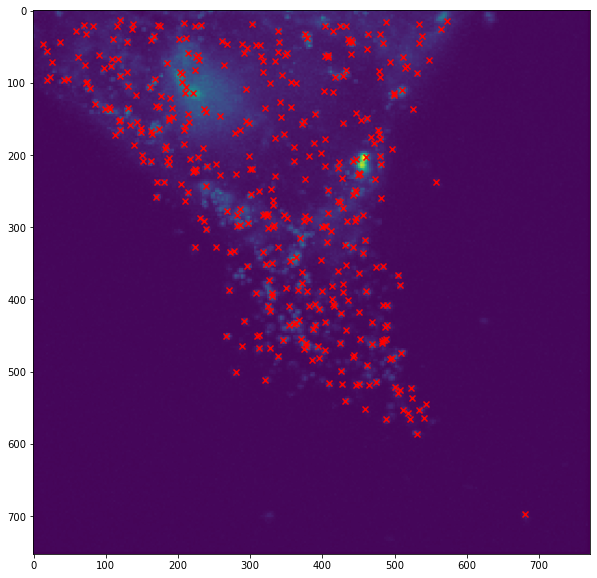

In [4]:
if(LoadData):
    # This will plot a max projection image of the last experiment with the localization marked on it
    debug_entire_exp(Max_Data_Set, coordinates, scale_size)

### Simulated Data Setup

If you chose to simulate the training data, you would need to specify the following parameters:

**numOfClusters** - Specifies the number of simulated clusters in each simulation (relevant only if CreateSimulatedData is set to True).

**bleach_proba** - Specifies the bleaching probability of the used fluorophore.

**TrainSetSize** - Specifies the number of simulated experiments to be created.

In [6]:
numOfClusters = 200
bleach_proba = 0.41
TrainSetSize = 10000

### Create Simulated Training Data

In [7]:
if(CreateSimulatedData):
    [X, y] = CreateSimulatedDataSet(TrainSetSize, numOfClusters, bleach_proba, numOfBins)
else:
    [X, y] = LoadSimulatedDataSet()

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75)
[X_train, X_val, X_test] = Normalization(X_train, X_val, X_test)
[X_train, X_val, X_test] = BiasTrick(X_train, X_val, X_test)
y_train = torch.FloatTensor(y_train)
y_val = torch.FloatTensor(y_val)

print("-I- Simulated Data was created successfully")

-I- Simulated Data was created successfully


### Build Model

In the next block we will build the neural network model.

**lr** - Specifies the training phase learning rate.

**betas** - Specifies the parameters for ADAM optimizer.

**batch_size** - Specifies the batch size of the training phase.

**epochs** - Specifies the maximal training epoch.

**early_stopping** - Specifies the tolerance of the neural network to lack of improvement in the validation loss. For example: early_stopping = 5, would stop the trainig phase if the validation loss did not improve for 5 epochs.

In [8]:
lr = 1e-5
betas = (0.99, 0.999)
batch_size = 4
epochs = 1000
early_stopping = np.min((int(epochs/5), 15))

### Training Phase

In [9]:
if(TrainNet):
    model = CustomNet(torch.numel(X_train[0]), [128, 128, 128, 128])
    
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)

    dl_train = CreateDataLoader(X_train, y_train, batch_size=batch_size)
    dl_val = CreateDataLoader(X_val, y_val, batch_size=1)

    # ================= Train Net ================
    trainer = Trainer(model, criterion, optimizer)
    trainer.fit(dl_train, dl_val, num_epochs=epochs, early_stopping=early_stopping, print_every=1)
    torch.save(trainer.model.state_dict(), 'model_final_gauss')

--- EPOCH 1/1000 ---


D:\MiniConda\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 : Train loss = 0.03491866961121559
Epoch 1 : Validation loss = 0.00491899810731411
--- EPOCH 2/1000 ---
Epoch 2 : Train loss = 0.0033436398953199387
Epoch 2 : Validation loss = 0.0024306552950292826
--- EPOCH 3/1000 ---
Epoch 3 : Train loss = 0.0020962366834282875
Epoch 3 : Validation loss = 0.0017875873018056154
--- EPOCH 4/1000 ---
Epoch 4 : Train loss = 0.001704948372207582
Epoch 4 : Validation loss = 0.001556574134156108
--- EPOCH 5/1000 ---
Epoch 5 : Train loss = 0.0015413656365126371
Epoch 5 : Validation loss = 0.0014541938435286283
--- EPOCH 6/1000 ---
Epoch 6 : Train loss = 0.0014557879185304046
Epoch 6 : Validation loss = 0.0013989013386890292
--- EPOCH 7/1000 ---
Epoch 7 : Train loss = 0.0014012648025527596
Epoch 7 : Validation loss = 0.0013634595088660717
--- EPOCH 8/1000 ---
Epoch 8 : Train loss = 0.0013617981458082795
Epoch 8 : Validation loss = 0.001337515888735652
--- EPOCH 9/1000 ---
Epoch 9 : Train loss = 0.0013310987269505858
Epoch 9 : Validation loss = 0.0013

### Load Pre-trained Model

In [25]:
if(TrainNet==False):
    model = CustomNet(torch.numel(X_train[0]), [128, 128, 128, 128])
    model.load_state_dict(torch.load(preTrainedModel))

<All keys matched successfully>

### Testing Phase

In [10]:
y_val_pred = model(X_val)
y_test_pred = model(X_test).squeeze()
y_test_pred = torch.max(y_test_pred, torch.zeros(y_test_pred.shape))

val_acc = torch.mean(torch.abs(y_val_pred.squeeze() - y_val))
print("Neural Network Validation MSE:", 100 * val_acc.item())

print("Dimers Percentage Predictions Per Experiment:")
if(y_test_pred.shape == torch.Size([])):
    print("0:", 100 * y_test_pred.item())
else:
    for i in range(y_test_pred.shape[0]):
        print("i:", 100 * y_test_pred[i].item())

Neural Network Validation MSE: 2.077123336493969
Dimers Percentage Predictions Per Experiment:
0: 61.41256093978882
